# Data Loading and Parsing

In [1]:
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.types import *

In [2]:
# - loas csv as RDD, csv stored at same path of ipython on remote machine
train_rdd = sc.textFile("./train.csv")
test_rdd = sc.textFile("./test.csv")
# train_rdd.take(3)
# train_rdd.count() # 892, correct
# test_rdd.count() # 419, correct
# test_rdd.take(3)


# - Train RDD to DataFrame
# - - use the header to build the fields for our schema (http://www.nodalpoint.com/spark-data-frames-from-csv-files-handling-headers-column-types/)
train_header = train_rdd.first()
train_rdd_temp = train_rdd.filter (lambda line: line!=train_header) # deleting header to prepare for dataframe 
train_header = train_header.replace('"','')  # get rid of the double-quotes
colnames = train_header.split(',')
colnames.insert(3,'FirstName') # It's a trap~ the name is in the forms of "firstname, mrs.tom jerry" with comma (https://6chaoran.wordpress.com/2016/08/13/__trashed/)
train_fields = [StructField(field_name, StringType(), True) for field_name in colnames]
train_fields[4].name = 'TitleLastname'

# will convert type later
# train_fields[0].dataType = IntegerType() # PassengerId
# train_fields[1].dataType = IntegerType() # Survived; sex, ticket, cabin,embarked are strings
# train_fields[2].dataType = IntegerType() # Pclass
# train_fields[6].dataType = FloatType() # age
# train_fields[7].dataType = IntegerType() # SibSp
# train_fields[8].dataType = IntegerType() # Parch
# train_fields[10].dataType = FloatType() # Fare
# train_fields

In [3]:
train_schema = StructType(train_fields)
# - - - use mapping to do the job (https://6chaoran.wordpress.com/2016/08/13/__trashed/) # (map can be used in this way! def function dealing with each row)
def parseRow(row): # later used for map function
    # remove double quote in names, spilt text row by comma; 
    row_list = row.replace('"','').split(",") # &quot; = " doesn't work
    # convert list to tuple to get compatible with pyspark data structure
    row_temp=[]
    
    for index in range(len(row_list)):
        if index in [0,1,2,7,8]:
            row_temp.append(row_list[index]) # need to convert type o.w. u'1'(unicode) cannot be convert to dataframe scheme with integer/ float defiend
        elif index in [6,10]:
            row_temp.append(row_list[index])
        else:
            row_temp.append(row_list[index])
    row_tuple = tuple(row_temp)
    return row_tuple

train_df_temp = train_rdd_temp.map(parseRow) # pyspark.rdd.PipelinedRDD
# train_df_temp.take(2)   
# train_df_temp.top(2) 

In [4]:
# - - rdd to dataframe
# method1 － http://www.nodalpoint.com/spark-data-frames-from-csv-files-handling-headers-column-types/
sqlContext = SQLContext(sc) # create a basic SQLContext object from class SQLContext
train_df = spark.createDataFrame(train_df_temp, train_schema)
# train_df.head(10)
train_df.show(3)


+-----------+--------+------+---------+--------------------+------+---+-----+-----+----------------+-------+-----+--------+
|PassengerId|Survived|Pclass|FirstName|       TitleLastname|   Sex|Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|
+-----------+--------+------+---------+--------------------+------+---+-----+-----+----------------+-------+-----+--------+
|          1|       0|     3|   Braund|     Mr. Owen Harris|  male| 22|    1|    0|       A/5 21171|   7.25|     |       S|
|          2|       1|     1|  Cumings| Mrs. John Bradle...|female| 38|    1|    0|        PC 17599|71.2833|  C85|       C|
|          3|       1|     3|Heikkinen|         Miss. Laina|female| 26|    0|    0|STON/O2. 3101282|  7.925|     |       S|
+-----------+--------+------+---------+--------------------+------+---+-----+-----+----------------+-------+-----+--------+
only showing top 3 rows



Above is the sample of training set after processing

In [5]:
# - Test RDD to DataFrame
# - - use the header to build the fields for our schema (http://www.nodalpoint.com/spark-data-frames-from-csv-files-handling-headers-column-types/)
test_header = test_rdd.first()
test_rdd_temp = test_rdd.filter (lambda line: line!=test_header) # deleting header to prepare for dataframe 
test_header = test_header.replace('"','')  # get rid of the double-quotes
colnames = test_header.split(',')
colnames.insert(2,'FirstName') # It's a trap~ the name is in the forms of "firstname, mrs.tom jerry" with comma (https://6chaoran.wordpress.com/2016/08/13/__trashed/)
test_fields = [StructField(field_name, StringType(), True) for field_name in colnames]
test_fields[3].name = 'TitleLastname'

# test_fields

test_schema = StructType(test_fields)
# test_rdd.take(3)
# - - - use mapping to do the job (https://6chaoran.wordpress.com/2016/08/13/__trashed/) # (map can be used in this way! def function dealing with each row)
def parseRow(row): # later used for map function
    # remove double quote in names, spilt text row by comma; 
    row_list = row.replace('"','').split(",") # &quot; = " doesn't work
    row_tuple = tuple(row_list)
    return row_tuple

test_df_temp = test_rdd_temp.map(parseRow) # pyspark.rdd.PipelinedRDD
test_df_temp.take(2)   
# test_df_temp.top(2) 


# - - rdd to dataframe
# method1 － http://www.nodalpoint.com/spark-data-frames-from-csv-files-handling-headers-column-types/
sqlContext = SQLContext(sc) # create a basic SQLContext object from class SQLContext（？）
test_df = spark.createDataFrame(test_df_temp, test_schema)
# test_df.head(10)
test_df.show(3)


+-----------+------+---------+--------------------+------+----+-----+-----+------+------+-----+--------+
|PassengerId|Pclass|FirstName|       TitleLastname|   Sex| Age|SibSp|Parch|Ticket|  Fare|Cabin|Embarked|
+-----------+------+---------+--------------------+------+----+-----+-----+------+------+-----+--------+
|        892|     3|    Kelly|           Mr. James|  male|34.5|    0|    0|330911|7.8292|     |       Q|
|        893|     3|   Wilkes| Mrs. James (Elle...|female|  47|    1|    0|363272|     7|     |       S|
|        894|     2|    Myles|  Mr. Thomas Francis|  male|  62|    0|    0|240276|9.6875|     |       Q|
+-----------+------+---------+--------------------+------+----+-----+-----+------+------+-----+--------+
only showing top 3 rows



Above is the sample of testing set after processing

In [6]:
# convert type now to double ((https://6chaoran.wordpress.com/2016/08/13/__trashed/) 
# assume pclass here is numerical, o.w. later we will still convert it from categorical to numerica
train_df = (train_df.withColumn('Age',train_df['Age'].cast("double"))
            .withColumn('SibSp',train_df['SibSp'].cast("double"))
            .withColumn('Parch',train_df['Parch'].cast("double"))
            .withColumn('Fare',train_df['Fare'].cast("double"))
            .withColumn('Survived',train_df['Survived'].cast("double"))
            .withColumn('Pclass',train_df['Pclass'].cast("double"))
            )
train_df.printSchema()

root
 |-- PassengerId: string (nullable = true)
 |-- Survived: double (nullable = true)
 |-- Pclass: double (nullable = true)
 |-- FirstName: string (nullable = true)
 |-- TitleLastname: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: double (nullable = true)
 |-- Parch: double (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)



Above is the info of training set after processing

In [7]:
test_df = (test_df.withColumn('Age',test_df['Age'].cast("double"))
            .withColumn('SibSp',test_df['SibSp'].cast("double"))
            .withColumn('Parch',test_df['Parch'].cast("double"))
            .withColumn('Fare',test_df['Fare'].cast("double"))
            .withColumn('Pclass',test_df['Pclass'].cast("double"))
            )
test_df.printSchema()

root
 |-- PassengerId: string (nullable = true)
 |-- Pclass: double (nullable = true)
 |-- FirstName: string (nullable = true)
 |-- TitleLastname: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: double (nullable = true)
 |-- Parch: double (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)



Above is the info of testing set after processing

# Data Cleaning 

##  missing data

In [8]:
trainVars = ['Survived','Age','SibSp','Parch','Fare','Sex','Cabin','Embarked']
testVars = ['Age','SibSp','Parch','Fare','Sex','Cabin','Embarked']
def countNull(df,attribute):
    return df.where(df[attribute].isNull()).count()
def reportNull(Vars,dataframe):
    dict={}
    for item in Vars:
        dict[item] = countNull(dataframe,item) 
    print(dict)
reportNull(trainVars,train_df)

{'Fare': 0, 'Embarked': 0, 'Age': 177, 'Parch': 0, 'Sex': 0, 'Survived': 0, 'SibSp': 0, 'Cabin': 0}


Above is the missing data of training set

In [9]:
reportNull(testVars,test_df)

{'Fare': 1, 'Embarked': 0, 'Age': 86, 'Parch': 0, 'Sex': 0, 'SibSp': 0, 'Cabin': 0}


Above is the missing data of test set

As the number of variables and missing records are higher than what we can affford to treat missing data by deleting them, we will fill missing data of age and fare with average of [training data]
(train data have 892 records, test data have 419 records) 

In [10]:
age_mean = train_df.groupBy().mean('Age').first()[0]
fare_mean = train_df.groupBy().mean('Fare').first()[0] # in fact, df has no function median, which is better than mean since there might be certain discrete levels 
# age_mean # 29.699117647066895
# fare_mean # 32.2042079685746
train_df = train_df.na.fill({'Age':age_mean,'Fare':fare_mean})

In fact, Cabin (lots of missing in both sets) and Embarked (2 missing in training set) also have missing data, but it was not detected! (why?)

In [11]:
# test_df.groupBy("Embarked").count().show()
train_df.groupBy("Embarked").count().show()

+--------+-----+
|Embarked|count|
+--------+-----+
|       Q|   77|
|       C|  168|
|       S|  644|
|        |    2|
+--------+-----+



Filling the missing Embarked data with the most common one 'S'

In [12]:
train_df = train_df.na.fill({'Embarked':'S','Fare':fare_mean})
test_df = test_df.na.fill({'Embarked':'S','Fare':fare_mean}) 

As there are a great amount of cabin data missing, I decided not to use this column, considering the fact that cabin (deck and location) can be highly related to fair (regardless of extreme expenses during the cruise, e.g., casino). in the future, I might also try predict cabin information from the data set. Also we will not touch varibales of passenger id, firstname, title&lastname, ticket, though title may reveal info like marriage status, royal call and so on.

In [14]:
drop_list = ['PassengerId','FirstName','Ticket','TitleLastname','Cabin']
train_df = train_df.select([column for column in train_df.columns if column not in drop_list])
# train_df.show(3)

drop_list_test = ['FirstName','Ticket','TitleLastname','Cabin']
test_df = test_df.select([column for column in test_df.columns if column not in drop_list])
# test_df.show(3)

## index categorical variable

Sex: male-0, female-1 | Embarked: S-0, C-1, Q-2

In [44]:
# catVars = ['Sex','Embarked']

## index Sex variable 
import numpy as np
from pyspark.ml.feature import StringIndexer
si_train_Sex = StringIndexer(inputCol = 'Sex', outputCol = 'Sex_indexed')
train_df_Sex = si_train_Sex.fit(train_df).transform(train_df).drop('Sex').withColumnRenamed('Sex_indexed','Sex') 
# index according to frequency in fit set: male-0, female-1
# train_df_Sex.show(5)
    
si_test_Sex = StringIndexer(inputCol = 'Sex', outputCol = 'Sex_indexed')
test_df_Sex = si_test_Sex.fit(train_df).transform(test_df).drop('Sex').withColumnRenamed('Sex_indexed','Sex')
# test_df_Sex.show(5)

## index Embarked variable 
si_train_Embarked = StringIndexer(inputCol = 'Embarked', outputCol = 'Embarked_indexed')
train_df_indexed = si_train_Embarked.fit(train_df).transform(train_df_Sex).drop('Embarked').withColumnRenamed('Embarked_indexed','Embarked')  
# index according to frequency in fit set: S-0, C-1, Q-2
train_df_indexed.show(5)

si_test_Embarked = StringIndexer(inputCol = 'Embarked', outputCol = 'Embarked_indexed')
test_df_indexed = si_test_Embarked.fit(train_df).transform(test_df_Sex).drop('Embarked').withColumnRenamed('Embarked_indexed','Embarked')
test_df_indexed.show(5)

+--------+------+----+-----+-----+-------+---+--------+
|Survived|Pclass| Age|SibSp|Parch|   Fare|Sex|Embarked|
+--------+------+----+-----+-----+-------+---+--------+
|     0.0|   3.0|22.0|  1.0|  0.0|   7.25|0.0|     0.0|
|     1.0|   1.0|38.0|  1.0|  0.0|71.2833|1.0|     1.0|
|     1.0|   3.0|26.0|  0.0|  0.0|  7.925|1.0|     0.0|
|     1.0|   1.0|35.0|  1.0|  0.0|   53.1|1.0|     0.0|
|     0.0|   3.0|35.0|  0.0|  0.0|   8.05|0.0|     0.0|
+--------+------+----+-----+-----+-------+---+--------+
only showing top 5 rows

+------+----+-----+-----+-------+---+--------+
|Pclass| Age|SibSp|Parch|   Fare|Sex|Embarked|
+------+----+-----+-----+-------+---+--------+
|   3.0|34.5|  0.0|  0.0| 7.8292|0.0|     2.0|
|   3.0|47.0|  1.0|  0.0|    7.0|1.0|     0.0|
|   2.0|62.0|  0.0|  0.0| 9.6875|0.0|     2.0|
|   3.0|27.0|  0.0|  0.0| 8.6625|0.0|     0.0|
|   3.0|22.0|  1.0|  1.0|12.2875|1.0|     0.0|
+------+----+-----+-----+-------+---+--------+
only showing top 5 rows



# Apply Machine Learning models

Before putting data into training, we need to convert features to formats that spark.mllib can accept for different algorithms

In [51]:
from pyspark.mllib.regression import LabeledPoint

train_rdd_indexed = train_df_indexed.rdd # map can only be applied to rdd rather than df

# Load and parse the data
def parsePoint(line):
    return LabeledPoint(line[0], line[1:])

parsedData = train_rdd_indexed.map(parsePoint)

# parsedData.take(3)

## split training data 

In [86]:
# Split data into training and test
train_data=[]
test_data=[]
number=[]
train_total=parsedData.count() # 891
rate=[0.01,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8]
for i in rate: 
    training, test = parsedData.randomSplit([i,1-i],seed=11)
    train_data.append(training)
    test_data.append(test)
    number.append(train_total*i)
# train_data[3].take(3)
trial=len(number) #15

## logistics regression and metrics

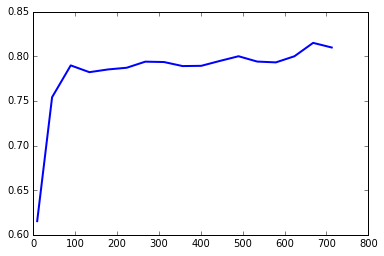

In [91]:
from pyspark.mllib.classification import LogisticRegressionWithLBFGS
from pyspark.mllib.util import MLUtils
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.mllib.classification import SVMWithSGD, SVMModel

Precision=[]
Recall=[]
F1Score=[]
WeightedF1Score_1=[]
Accuracy=[]

for i in range(trial):

    # Run training algorithm to build the model
    model = LogisticRegressionWithLBFGS.train(train_data[i], numClasses=2)


    # Compute raw scores on the test set
    predictionAndLabels = test_data[i].map(lambda lp: (float(model.predict(lp.features)), lp.label))

    # Accuracy
    
    trainErr = predictionAndLabels.filter(lambda (v, p): v != p).count() / float(test_data[i].count())
    Accuracy.append(1-trainErr)
    
    # Instantiate metrics object
    metrics = MulticlassMetrics(predictionAndLabels)

    # Overall statistics
    Precision.append(metrics.precision())
    Recall.append( metrics.recall())
    F1Score.append(metrics.fMeasure())
    WeightedF1Score_1.append(metrics.weightedFMeasure())

    
import matplotlib.pyplot as plt
plt.plot(number,Accuracy, linewidth=2.0)
plt.show()



plt.plot(number,F1Score, linewidth=2.0)
plt.show()


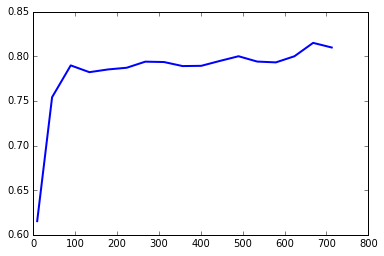

In [92]:
plt.plot(number,F1Score, linewidth=2.0)
plt.show()

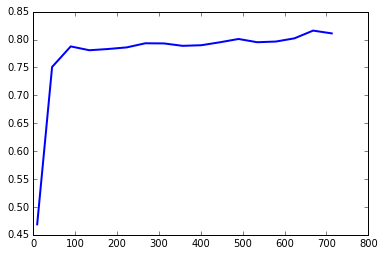

In [93]:
plt.plot(number,WeightedF1Score_1, linewidth=2.0)
plt.show()

## Random Forest